$$-\Delta u = 100 \sin(\pi x)$$ in $\Omega$ with $u = 0$ on $\partial \Omega$

Exact solution $$u(x) = \dfrac{100 \sin(\pi x)}{\pi^2}$$

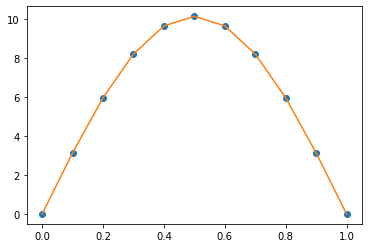

3.552713678800501e-15


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
    
M = 10 #points in x
L = 1 #endpoint
x = np.linspace(0,L,M+1)
h = x[1]-x[0]


def uex(x):
    return((100*np.sin(np.pi*x ))/np.pi**2)

    
def stiffassembly(M):
    diag = np.zeros(M-1) #x_1,...,x_{M-1} (M-1)
    offd = np.zeros(M-2) #off diagonal terms
    for i in range(1,M):
        diag[i-1] = 1/h +1/h
    
    for k in range(1,M-1):
        offd[k-1] = -1/h
    
    A = np.diag(offd,-1) + np.diag(diag,0) + np.diag(offd,+1)
    return A
    
    

def f(x):
    return 100*np.sin(np.pi*x)
    
    
def load(M):
    load = np.zeros(M-1)
    for k in range(1,M):
        load[k-1] = integrate.quad(lambda w: f(w)*(1/h)*(w-x[k-1]),x[k-1],x[k])[0] \
                  + integrate.quad(lambda w: f(w)*(1/h)*(x[k+1]-w),x[k],  x[k+1])[0]
        
    return load
    

u = np.linalg.solve(+stiffassembly(M) ,load(M))
U = np.r_[0,u,0]
plt.plot(x,U,'o',x,uex(x),'-')
plt.show()
plt.show()
error = np.linalg.norm(U-uex(x),np.inf)    
print(error)

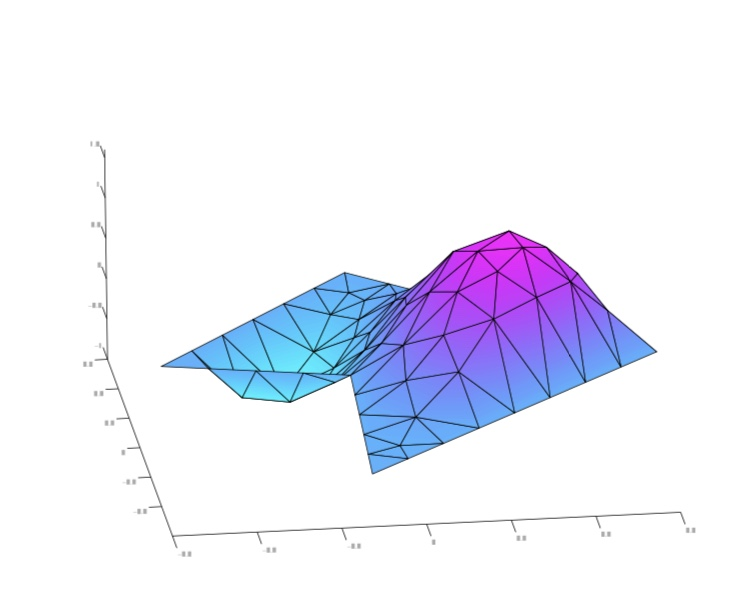

In [1]:
from IPython.display import Image
Image(filename ="/Users/nikosmatsavelas/Desktop/IMG_8351.jpg")

In [2]:
import numpy as np
from skfem import LinearForm
@LinearForm
def loading(v, w):
    return(np.sin(np.pi * w.x[0]) * v)

In [ ]:
from skfem import *
from skfem.models.poisson import *
import numpy as np
from scipy.sparse import spmatrix
from scipy.sparse.linalg import LinearOperator

p = np.linspace(0, 1, 16)
m = MeshTet.init_tensor(*(p,) * 3)

e = ElementTetP1()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(loading, basis)

I = m.interior_nodes()

x = 100. * b

if __name__ == "__main__":
    verbose = True
else:
    verbose = False

Aint, bint = condense(A, b, I=I, expand=False)

preconditioners = [None, build_pc_ilu(Aint, drop_tol=1e-3)]

try:
    from pyamg import smoothed_aggregation_solver

    def build_pc_amgsa(A: spmatrix, **kwargs) -> LinearOperator:
        """AMG (smoothed aggregation) preconditioner"""
        return smoothed_aggregation_solver(A, **kwargs).aspreconditioner()

    preconditioners.append(build_pc_amgsa(Aint))

except ImportError:
    print('Skipping PyAMG')

try:
    import pyamgcl

    def build_pc_amgcl(A: spmatrix, **kwargs) -> LinearOperator:
        """AMG preconditioner"""

        if hasattr(pyamgcl, 'amgcl'):  # v. 1.3.99+
            return pyamgcl.amgcl(A, **kwargs)
        else:
            return pyamgcl.amg(A, **kwargs)

    preconditioners.append(build_pc_amgcl(Aint))

except ImportError:
    print('Skipping pyamgcl')

for pc in preconditioners:
    x[I] = solve(Aint, bint, solver=solver_iter_pcg(verbose=verbose, M=pc))


if verbose:
    from os.path import splitext
    from sys import argv

    m.save(splitext(argv[0])[0] + ".vtk", {'potential': x})